# Unsupervised Learning and Dimensionality Reduction

Things to do:
 - Rerun the Neural Network on the Adult Data using all samples and a scaler
 - Run k-means and EM algorithms on the scaled Adult Data. Describe what you see
 - Run PCA, ICA, and Randomized Projects on the scaled adult data. Describe what you see.
 - Rerun k-means and EM on the data after it has been run through each dimensionality reduction algorithm
 - Rerun Neural Network on dimensionality reduced Adult Data
 - Rerun Neural Network on clustered data (use clusters as features)

# Load in Adult Data and Preprocess

In [9]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.cluster import KMeans

In [3]:
train = pd.read_csv('adult_train.csv')
test = pd.read_csv('adult_test.csv')
test["income"] = test.income.apply(lambda x: x[:-1])
adult_data = pd.concat([train, test])

In [4]:
categorical_columns = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "race", "sex", "native_country", "income"]

adult_data = pd.get_dummies(adult_data, columns=categorical_columns)

In [5]:
y = adult_data["income_ >50K"]
X = adult_data.drop(["income_ >50K", "income_ <=50K"], axis=1)
X_columns = X.columns

In [6]:
y_train, y_test = train_test_split(y, test_size=0.1, stratify=y, random_state=42)
X_train, X_test = train_test_split(X, test_size=0.1, stratify=y, random_state=42)

# Run on a Neural Net

In [ ]:
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("nn", MLPClassifier())
])

parameters = {
    'nn__hidden_layer_sizes' : [tuple([x] * n) for x in range(10,100,10) for n in range(1,5)]
}

grid_search = GridSearchCV(clf, parameters, cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

names = grid_search.cv_results_['param_nn__hidden_layer_sizes']
scores = grid_search.cv_results_['mean_test_score']

for name, score in zip(names, scores):
    print(f'{name}:\t\t\t {score}')

In [ ]:
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("nn", MLPClassifier())
])

parameters = {
    'nn__hidden_layer_sizes' : [tuple([x]) for x in range(1, 20)]
}

grid_search = GridSearchCV(clf, parameters, cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

names = grid_search.cv_results_['param_nn__hidden_layer_sizes']
scores = grid_search.cv_results_['mean_test_score']

for name, score in zip(names, scores):
    print(f'{name}:\t\t\t {score}')

I performed a grid search on the standardized data, first testing one to five hidden layers of 10 to 100 nodes each. The search found that a single layer of 10 was the optimum, but only by a small amount. The second grid search tested a single hidden layer with one to twenty nodes. Above 3 nodes, all cross validation scores were within a fraction of a percent of each other. All neural nets in this experiment moving forward used a single hidden layer of 5 nodes.

In [7]:
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("nn", MLPClassifier(hidden_layer_sizes=(5)))
])

cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10).mean()

0.8536522844578915

# Analysis Through K-Means

In [50]:
cluster_error = pd.DataFrame(columns=["k", "inertia"])

kmeans_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans())
])

for k in range(1, 101):
    kmeans_pipeline = kmeans_pipeline.set_params(kmeans__n_clusters=k).fit(X_train)
    cluster_error = cluster_error.append({"k": k, "inertia" : -kmeans_pipeline.score(X_train)/len(X_train)},
                                         ignore_index=True)
    
cluster_error

,k,inertia
0,1.0,108.000000
1,2.0,104.139930
2,3.0,102.291395
3,4.0,100.702236
4,5.0,99.288534
5,6.0,97.779112
6,7.0,97.184326
7,8.0,95.807973
8,9.0,94.977227
9,10.0,94.229922


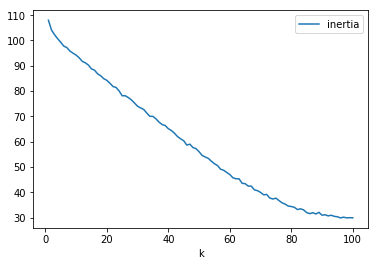

In [53]:
cluster_error.to_csv('bncluster')